In [28]:
# Import libraries
import os
import re
import csv
import nltk
import pickle
import urllib
import string
import sqlite3
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics
from bs4 import BeautifulSoup
from argparse import Namespace
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.stem import PorterStemmer
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_auc_score
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,hamming_loss

%matplotlib inline
warnings.filterwarnings("ignore")

color = sns.color_palette()

### Description

Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.

Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.

### Problem Statemtent

Suggest the tags based on the content that was there in the question posted on Stackoverflow.

Source: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/

## Data reading

In [3]:
# Read train data
df = pd.read_csv('Train.csv', index_col=0)
print("Number of data points:",df.shape)

Number of data points: (6034195, 3)


In [5]:
# Read test data
df_test = pd.read_csv('Test.csv', index_col=0)
print("Number of data points:",df_test.shape)

Number of data points: (2013337, 2)


In [4]:
df.head(5)

,Title,Body,Tags
Id,,,
1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [6]:
df_test.head(5)

,Title,Body
Id,,
6034196,Getting rid of site-specific hotkeys,<p>How do I disable site-specific hotkeys if (...
6034197,Nodes inside Cisco VPN. Incoming SSH requests ...,<p>I've a gateway-to-gateway VPN setup between...
6034198,Remove old vCenter servers from VMWare vSphere...,<p>After changing our vCenter servers recently...
6034199,Replace <span> element with var containing html,"<p>I have a variable i lifted the contents of,..."
6034200,Will PHP included html content affect my seo?,<p>Today i purchase a small CMS system. With t...


## Finding and removing duplicates from data

In [8]:
# find duplicate data
df[df.duplicated(subset=['Title', 'Body', 'Tags'])].shape

(1827881, 3)

In [9]:
# drop duplicate data
df.drop_duplicates(subset=['Title', 'Body', 'Tags'], keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)


(4206314, 3)


In [10]:
df.head(10)

,Title,Body,Tags
0,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents
5,setting proxy in active directory environment,<p>I am using a machine on which active direct...,proxy active-directory jmeter
6,How to draw barplot in this way with Coreplot,<p>My image is cannot post so the link is my ...,core-plot
7,How to fetch an XML feed using asp.net,<p>I've decided to convert a Windows Phone 7 a...,c# asp.net windows-phone-7
8,.NET library for generating javascript?,<p>Do you know of a .NET library for generatin...,.net javascript code-generation
9,"SQL Server : procedure call, inline concatenat...",<p>I'm using SQL Server 2008 R2 and was wonder...,sql variables parameters procedure calls


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206314 entries, 0 to 4206313
Data columns (total 3 columns):
Title    object
Body     object
Tags     object
dtypes: object(3)
memory usage: 96.3+ MB


In [12]:
df.describe()

,Title,Body,Tags
count,4206314,4206314,4206307
unique,4125233,4154381,2110906
top,Object reference not set to an instance of an ...,<p>Is it possible?</p>\n,android
freq,37,9,35794


## count of each review

In [13]:
df = df.groupby(['Title', 'Body', 'Tags']).size().reset_index(name='count')

In [18]:
df.head(4)

,Title,Body,Tags,count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1


In [22]:
df['count'].value_counts()

1    4206307
Name: count, dtype: int64

## Tag count

In [24]:
df['Tag_count'] = df.Tags.apply(lambda tag: len(tag.split(' ')))

In [25]:
df.head(4)

,Title,Body,Tags,count,Tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2


In [26]:
df.Tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568290
5     505158
Name: Tag_count, dtype: int64

## Save filtered reviews

In [28]:
no_dup = pd.DataFrame(df, columns=['Title', 'Body', 'Tags'])
no_dup.to_csv('no_dup_train.csv')

# Tag Analysis

## Unique tags

In [30]:
tag_df = pd.read_csv('no_dup_train.csv', usecols=['Tags'])
tag_df.head(3)

,Tags
0,c++ c
1,c# silverlight data-binding
2,c# silverlight data-binding columns


In [31]:
count_vec = CountVectorizer(tokenizer= lambda x: x.split())
tag_vector = count_vec.fit_transform(tag_df['Tags'])

In [32]:
print("Number of data points :", tag_vector.shape[0])
print("Number of unique tags :", tag_vector.shape[1])

Number of data points : 4206307
Number of unique tags : 42048


In [33]:
tag_name = count_vec.get_feature_names()
print(tag_name[0:10])

['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


In [34]:
freqs = tag_vector.sum(axis=0).A1
result = dict(zip(tag_name, freqs))

In [35]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_count_vec.csv'):
    with open('tag_counts_dict_count_vec.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_count_vec.csv", names=['Tags', 'Counts'])
tag_df.head(5)

,Tags,Counts
0,picasa-web,3
1,buttonbar,19
2,public-fields,9
3,message-queue,781
4,dirtree,11


In [36]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values
tag_counts

array([331505, 299414, 284103, ...,      1,      1,      1])

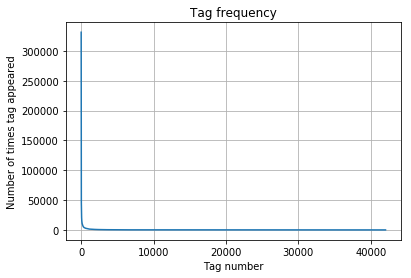

In [37]:
plt.plot(tag_counts)
plt.title('Tag frequency')
plt.ylabel('Number of times tag appeared')
plt.xlabel('Tag number')
plt.grid()
plt.show()

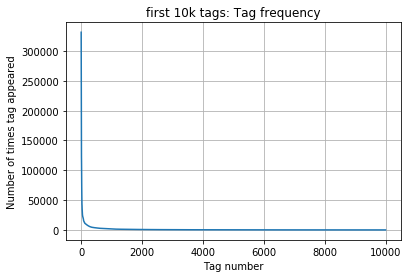

In [38]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Tag frequency')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

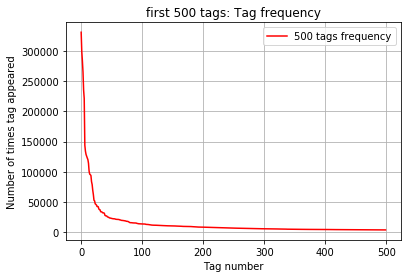

In [39]:
plt.plot(tag_counts[0:500], c='r', label='500 tags frequency')
plt.title('first 500 tags: Tag frequency')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

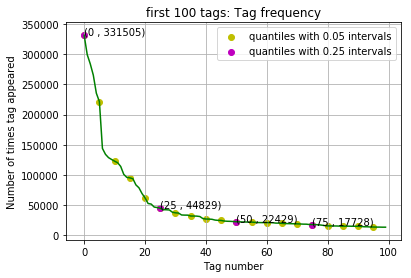

In [40]:
plt.plot(tag_counts[0:100], c='g')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='y', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Tag frequency')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

In [41]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


## Tags Per Question

In [53]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_vector.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206307 datapoints.
[2, 3, 4, 2, 2]


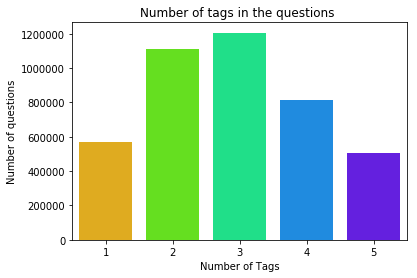

In [54]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

## Most Frequent Tags

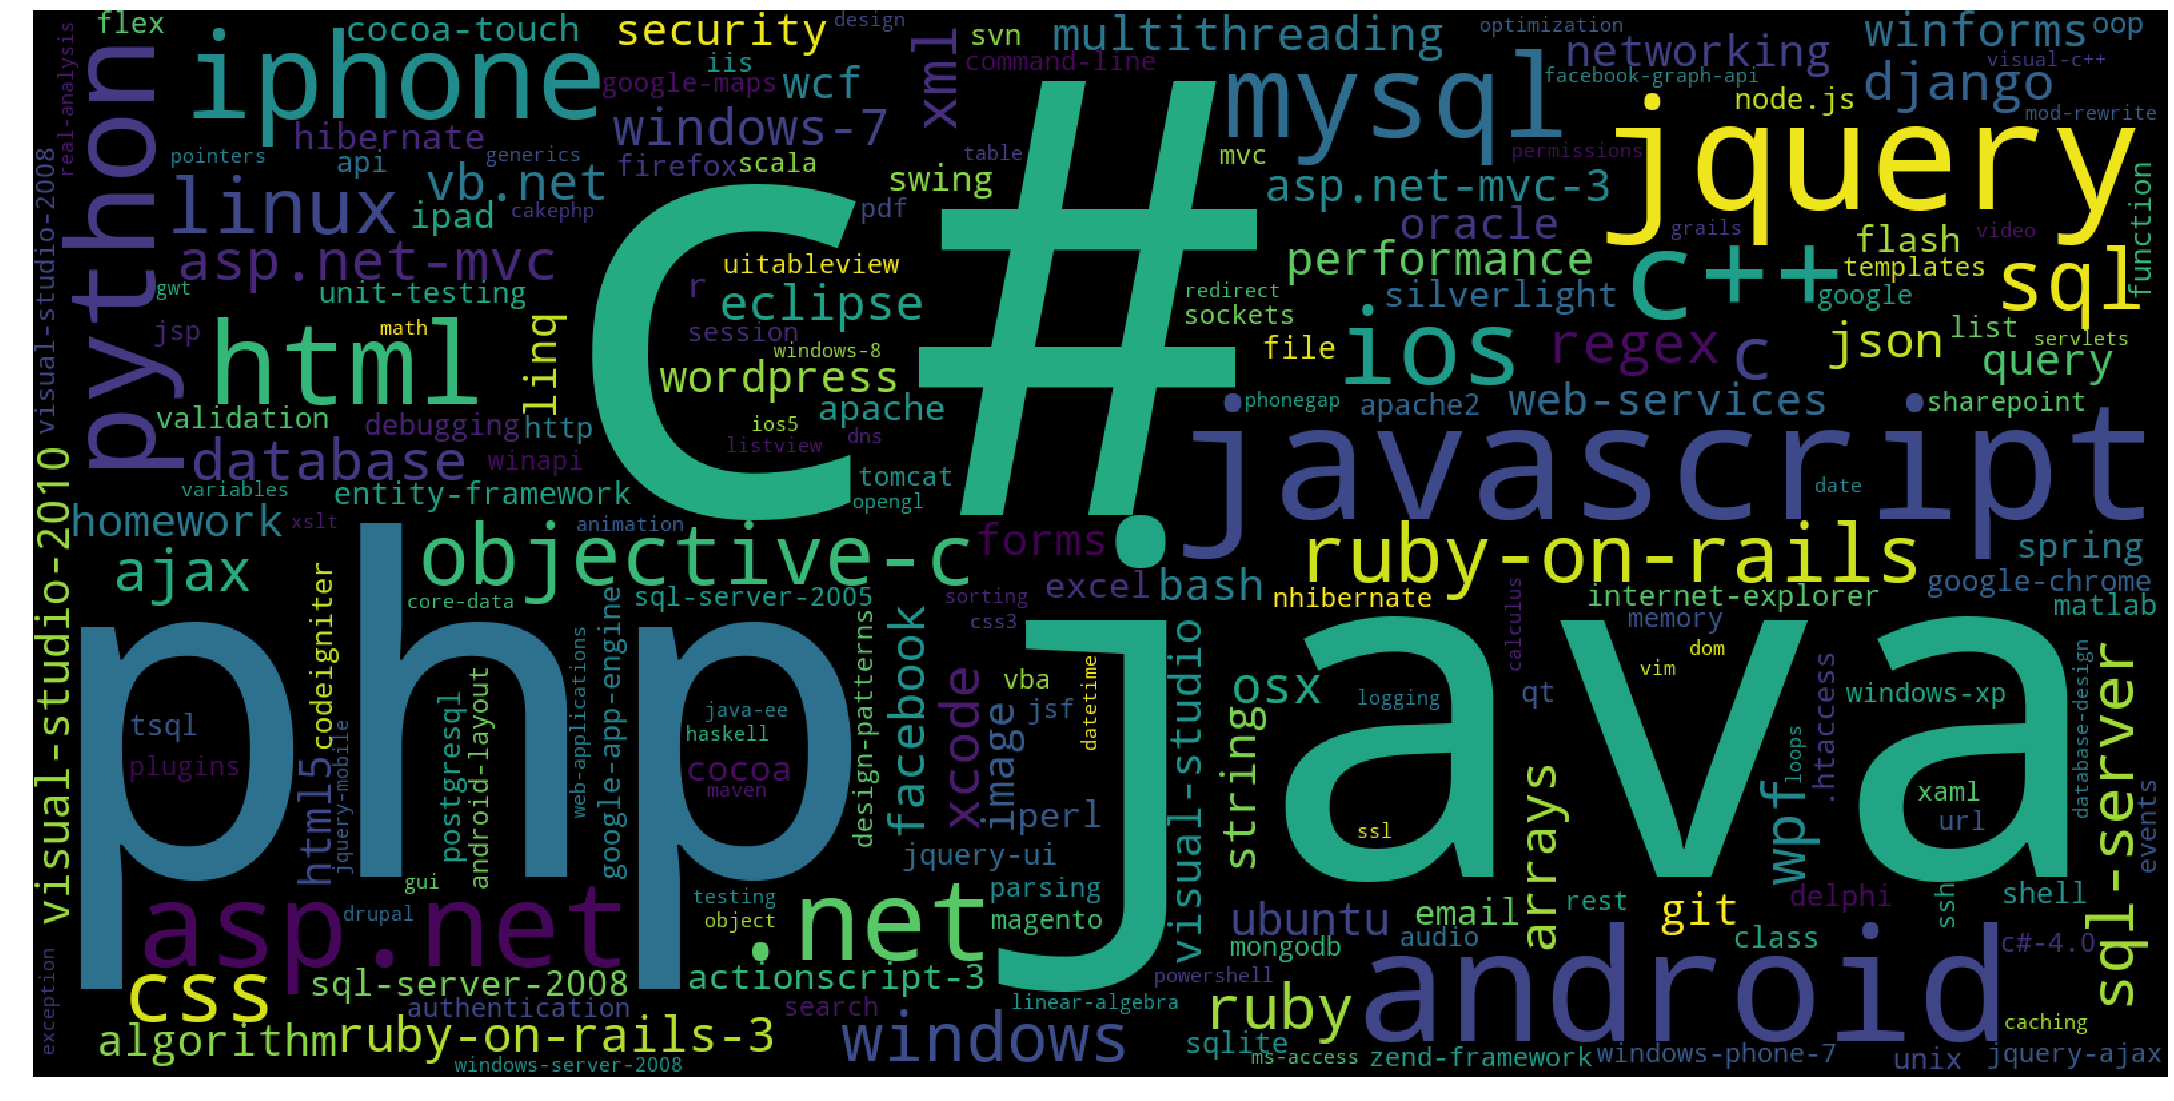

In [60]:
# Ploting word cloud
%timeit

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()


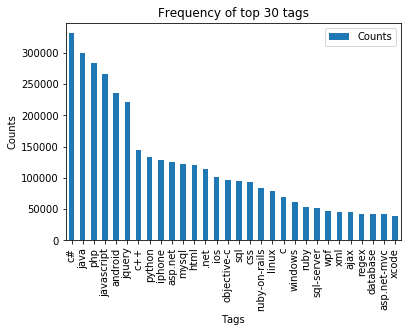

In [64]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 30 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

## Cleaning and preprocessing of Questions 

### Preprocessing

1. Separate out code-snippets from Body
2. Remove Spcial characters from Question title and description (not in code)
3. Remove stop words (Except 'C')
4. Remove HTML Tags
5. Convert all the characters into small letters
6. Use SnowballStemmer to stem the words

In [74]:
question_df = pd.read_csv('no_dup_train.csv', index_col=0)

In [75]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [ ]:
from datetime import datetime
start = datetime.now()
processed_question = pd.DataFrame(columns = ['question','code','tags','words_pre','words_post','is_code'])
preprocessed_data_list=[]
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
question_df_mini = question_df[:1000000]
for index, row in enumerate(question_df_mini.iterrows()):
    is_code = 0
    title, question, tags = row[1]['Title'], row[1]['Body'], row[1]['Tags']

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
#     print(question)
#     print(question, code, tags, x, len(question), is_code)
    r = [question, code, tags, x, len(question), is_code]
    processed_question.loc[index] = r
#     writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%10000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)


In [118]:
processed_question.shape

(257241, 6)

In [119]:
processed_question.to_csv('processed_question.csv', index=False)

In [3]:
processed_data = pd.read_csv('processed_question.csv', usecols=['question', 'tags'])
processed_data.head(4)

,question,tags
0,implement boundari valu analysi softwar test c...,c++ c
1,dynam datagrid bind silverlight bind datagrid ...,c# silverlight data-binding
2,dynam datagrid bind silverlight bind datagrid ...,c# silverlight data-binding columns
3,java lang noclassdeffounderror javax servlet j...,jsp jstl


In [4]:
print("number of data points in sample :", processed_data.shape[0])
print("number of dimensions :", processed_data.shape[1])

number of data points in sample : 257241
number of dimensions : 2


In [5]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(processed_data['tags'])

In [6]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [7]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=processed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))
    
questions_explained[:6]

[91.457999999999998,
 92.575000000000003,
 93.453999999999994,
 94.037999999999997,
 94.643000000000001,
 95.088999999999999]

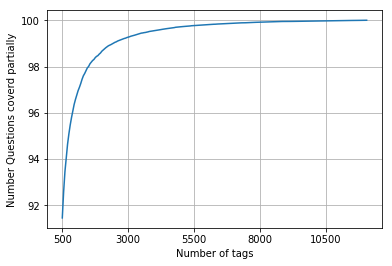

with  5500 tags we are covering  99.268 % of questions


In [9]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [10]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 1884 out of  257241


In [11]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 23685
number of tags taken : 5500 ( 23.221448173949756 %)


In [13]:
total_size=processed_data.shape[0]
train_size=int(0.80*total_size)

x_train=processed_data.head(train_size)
x_test=processed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [14]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (205792, 5500)
Number of data points in test data : (51449, 5500)


In [16]:

vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])


In [17]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (205792, 97102) Y : (205792, 5500)
Dimensions of test data X: (51449, 97102) Y: (51449, 5500)


In [ ]:
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=21)

# train
classifier.fit(x_train_multilabel, y_train)

# predict
predictions = classifier.predict(x_test_multilabel)


In [27]:
print(accuracy_score(y_test,predictions))
print(f1_score(y_test, predictions, average = 'macro'))
print(f1_score(y_test, predictions, average = 'micro'))
print(hamming_loss(y_test,predictions))

0.0511185834516
0.0805485888062
0.254104186925
0.0004635517255393249


## Applying Logistic Regression with OneVsRest Classifier

In [ ]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))